<a href="https://colab.research.google.com/github/Lawrence-Krukrubo/fraud_analyst_assignment/blob/main/03_diagnostic_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First let's mount Google Drive so we can navigate the folders as needed
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Let's import some much needed libraries...**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import random
import xlrd
print('done!')

done!


In [3]:
# Let's get all the colors available in matplotlib
other_colors = []
darker_colors = []
for name, hex in mpl.colors.cnames.items():
    if 'dark' in name:
        darker_colors.append(name)
    else:
        other_colors.append(name)

# Let's finally save the various plot styles in matplotlib
styles = plt.style.available

print(f'darker-colors has {len(darker_colors)},\nother-colors has {len(other_colors)} colors\nplotting styles are {len(styles)}')

darker-colors has 19,
other-colors has 129 colors
plotting styles are 26


In [4]:
# set more matplotlib defaults
def set_rcParams():
    mpl.rcParams['axes.labelsize'] = 12
    mpl.rcParams['xtick.labelsize'] = 10
    mpl.rcParams['ytick.labelsize'] = 10
    mpl.rcParams['text.color'] = 'k'
    mpl.rc('lines', linewidth=4, linestyle='-')
    print('rcParams set!')

# Set the plots design to xkcd
# plt.xkcd()  # For xkcd style plots
#plt.rcdefaults()  # to stop xkcd plots

# fontdict for plot titles
fontDict1 = {'fontfamily': 'fantasy',
             'fontsize': 'x-large',
             'fontstyle': 'italic',
             'fontweight': 'heavy',
             'ha': 'center',
             'color': 'darkred',
             'va': 'baseline'}

# fontdict for plot labels
fontDict2 = {'fontfamily': 'fantasy',
             'fontsize': 'medium',
             'fontstyle': 'oblique',
             'fontweight': 'semibold',
             'ha': 'center',
             'color': 'black',
             'va': 'baseline'}

set_rcParams()

rcParams set!


**Let's change our Directory to the Fraud directory containing our data**

In [5]:
FRAUD_DIR = '/content/gdrive/MyDrive/Colab_Notebooks/fraud_analyst_assignment'
os.chdir(FRAUD_DIR)
print(f'Current Dir: {os.getcwd()}')

Current Dir: /content/gdrive/MyDrive/Colab_Notebooks/fraud_analyst_assignment


In [6]:
# Let's see the contents of the CWD
os.listdir()

['Fraud_sample_data.xlsx',
 'questionsAndPoints.gdoc',
 '.ipynb_checkpoints',
 '01_intro_to_fraud_analysis.ipynb',
 '04_predictive_analytics.ipynb',
 '05_prescriptive_analytics.ipynb',
 'fraud_analysis.ipynb',
 'july_df.csv',
 'june_df.csv',
 'data_dict.csv',
 '02_descriptive_analytics.ipynb',
 '03_diagnostic_analytics.ipynb']

# Diagnostic EDA (DA2):

**Diagnostic Analytics (DA2):**<br>
Diagnostic analytics are a deeper look at data to attempt to understand the causes of events and behaviours. It’s used largely to answer the question **[“Why did it happen?”]**, and to discover intricate patterns in the data. It is characterized by techniques such as : **drill-down** • **data discovery** • **data mining** • **correlations** • **mutual-information**

1. On a weekly basis, what weeks have the most Fraud?
2. Is there a correlation between weekly transactions count and fraud count?
3. Does fraud tend to increase due to social reasons like public holidays?
4. What Industries are most prone to Fraud?
5. What type of Merchants is most prone?
6. What features of the data are strongly related to fraud occurrences? We can try using Mutual-Information and correlation
7. What are the common patterns among merchants who record the most fraud? For example... 
* What's the average transactions volume per week for high-risk merchants and others? 
* Is there a correlation between fraud-count and transaction-volume-USD when compared to high-risk and other merchants?
* Is there a correlation between weekly fraud count and transaction count for high-risk merchants?
8. Can we use clustering algorithms to learn any meaningful patterns or groupings that can help us learn more about the recent fraud spikes?

Asking and answering these questions give us a deeper understanding of the causes or patterns related to the spike in fraud.

### 1. Exploring Correlation and Dealing with Multi-Correlated Features

The aim here is to identify redundant features that may be too correlated with each other and deal with them before applying Mutual-Information to select the top discriminative features for Clustering - Machine Learning. This is essential because highly-correlated features can skew our clustering result. So instead, we keep one of such features rather than both.

**First, let's read in our June and July datasets from the descriptive analytics session.**

In [7]:
june_df = pd.read_csv('june_df.csv')
july_df = pd.read_csv('july_df.csv')

print(f'june-df shape is: {june_df.shape}\njuly-df shape is: {july_df.shape}\n')
june_df.head()

june-df shape is: (8609, 13)
july-df shape is: (8809, 13)



,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-06-07,card,5,231.590551,0,0.0,0,5
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-06-07,card,2,210.203412,0,0.0,0,2
2,9,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-06-07,card,4,223.097113,0,0.0,0,1
3,11,SERVICES-PROFESSIONAL,Other,Nigeria,NGN,2021-06-07,card,5,212.335958,0,0.0,0,5
4,15,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-06-07,card,8,550.131234,0,0.0,0,8


**Next, let's combine both datasets...**


In [8]:
combined_df = pd.concat([june_df, july_df], ignore_index=True)
print(f'combined-df shape is: {combined_df.shape}\n')
combined_df.head()

combined-df shape is: (17418, 13)



,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-06-07,card,5,231.590551,0,0.0,0,5
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-06-07,card,2,210.203412,0,0.0,0,2
2,9,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-06-07,card,4,223.097113,0,0.0,0,1
3,11,SERVICES-PROFESSIONAL,Other,Nigeria,NGN,2021-06-07,card,5,212.335958,0,0.0,0,5
4,15,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-06-07,card,8,550.131234,0,0.0,0,8


**Check for possible NaN values after combination**

In [9]:
combined_df.isna().any().sum()

0

**Next create the correlation matrix**

In [10]:
corr_df = combined_df._get_numeric_data()
corr_data = corr_df.corr()

**Visualize Correlation**

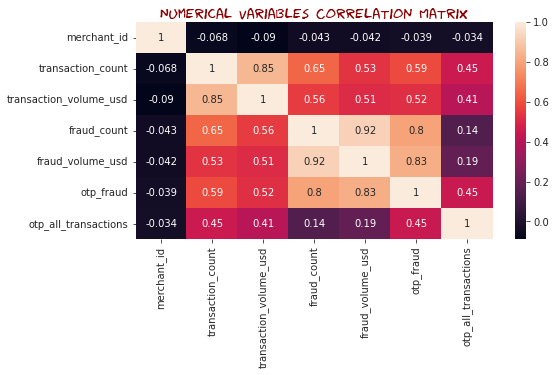

In [11]:
sns.set_style('ticks')
plt.figure(figsize=(8,4))
plt.title('Numerical Variables Correlation Matrix', fontdict=fontDict1)

sns.heatmap(corr_data, annot=True)

plt.show()

From the correlation matrix, we can see some very strongly correlated features.
* `fraud_volume_usd` and `fraud_count` are strongly correlated.
* So are `transaction_volume_usd` and `transaction_count`
* Also `fraud_volume_usd` and `fraud_count`

In [12]:
pd.set_option('max_colwidth', None)  # So that we see full field descriptions
data_dict = pd.read_csv('data_dict.csv', )
data_dict

,Field name,Field description
0,merchant_id,Randomly generated identifier to represent a merchant
1,merchant_industry,Industry in which the merchant operates
2,merchant_category,Business category of the merchant
3,merchant_country,The country in which the merchant is based
4,currency,The local currency the transcation was processed in
5,transaction_week_start_date,Week in which the transaction occured
6,channel,The payment method for the transaction
7,transaction_count,The number of transactions for the day
8,transaction_volume_usd,The total value of the transactions converted to USD
9,fraud_count,The number of transactions which were reported as fraudulent for the day


**Checking for Multicolinearity**
**Applying Variance-Inflation-Factor**
We shall use VIF to determine the overall columns with high multi-collinearity and seive them out... See a [link](https://github.com/Lawrence-Krukrubo/Understanding_Multiple_Linear_Regression/blob/master/coefficients_of_multiple_linear_regression.ipynb) to myprevious work on this

In [13]:
corr_data

,merchant_id,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
merchant_id,1.000000,-0.067540,-0.090443,-0.042657,-0.042238,-0.038966,-0.034410
transaction_count,-0.067540,1.000000,0.852414,0.649697,0.531915,0.589844,0.452566
transaction_volume_usd,-0.090443,0.852414,1.000000,0.556070,0.511363,0.524742,0.407764
fraud_count,-0.042657,0.649697,0.556070,1.000000,0.924044,0.798457,0.143113
fraud_volume_usd,-0.042238,0.531915,0.511363,0.924044,1.000000,0.828687,0.189120
otp_fraud,-0.038966,0.589844,0.524742,0.798457,0.828687,1.000000,0.448826
otp_all_transactions,-0.034410,0.452566,0.407764,0.143113,0.189120,0.448826,1.000000


**Let's select the highly correlated variables and measure VIF**

In [14]:
col_names = list(corr_data.columns)
high_corrs = set()
t = 0.65  # let's take a threshold of 0.65

for index, row in corr_data.iterrows():
    count = -1
    for r in row:
        count+=1
        if abs(r) >= t:
            x = col_names[count]
            high_corrs.add(x)

# convert high-corrs set to a list
high_corrs = list(high_corrs)
high_corrs

['fraud_count',
 'merchant_id',
 'otp_all_transactions',
 'fraud_volume_usd',
 'otp_fraud',
 'transaction_volume_usd',
 'transaction_count']

**To calculate multicolinearity using VIF**

In [15]:
# First we create a dataframe of only high corrs

high_corrs_df = combined_df[high_corrs]
high_corrs_df.head(3)

,fraud_count,merchant_id,otp_all_transactions,fraud_volume_usd,otp_fraud,transaction_volume_usd,transaction_count
0,0,1,5,0.0,0,231.590551,5
1,0,5,2,0.0,0,210.203412,2
2,0,9,1,0.0,0,223.097113,4


In [16]:
# Next, we standardize the data columns

def standardize(data_features):
    data_features = (data_features - data_features.mean()) / data_features.std()
    return data_features

high_corrs_df = high_corrs_df.apply(standardize, axis=0)
high_corrs_df.head(3)

,fraud_count,merchant_id,otp_all_transactions,fraud_volume_usd,otp_fraud,transaction_volume_usd,transaction_count
0,-0.03199,-1.730877,-0.042632,-0.031088,-0.03534,-0.093427,-0.058879
1,-0.03199,-1.729286,-0.043748,-0.031088,-0.03534,-0.093735,-0.059259
2,-0.03199,-1.727696,-0.044121,-0.031088,-0.03534,-0.093549,-0.059006


In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    """This function takes a dataframe of
    variables with highest correlation figures
    and computes the VIF score per variable.

    @param df: A dataframe
    @return: A dataframe of VIF scores per variable
    """
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns

    return vif

vif = calculate_vif(high_corrs_df)
vif

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



,VIF_Factor,features
0,11.515174,fraud_count
1,1.008644,merchant_id
2,1.943517,otp_all_transactions
3,9.956770,fraud_volume_usd
4,4.727605,otp_fraud
5,4.021690,transaction_volume_usd
6,5.918621,transaction_count


Ideally, we want our VIF score per variable to be between 1 and 5, values above 10 have high multicollinearity, so we remove one and try again.

In [18]:
# Let's drop fraud_volume_usd since fraud_count is our target
high_corrs_df.drop(['fraud_volume_usd'], axis=1, inplace=True)

# Let's recompute VIF
vif = calculate_vif(high_corrs_df)
vif

,VIF_Factor,features
0,4.592011,fraud_count
1,1.008624,merchant_id
2,1.932926,otp_all_transactions
3,4.137498,otp_fraud
4,3.689188,transaction_volume_usd
5,4.872980,transaction_count


**And pleasantly, our VIF scores are all below 5. This means we have dealt decisively with multicollinearity issues in the data and sets all variables ready for Machine-Learning.**

### 2. Exploring Mutual-Information (MI) of variables:
Mutual information describes relationships in terms of uncertainty. The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

Mutual information is how many questions you expect the feature to answer about the target. It can help to understand the relative potential of a feature as a predictor of the target, considered by itself. But Mutual Information can't detect interactions between features, is a Univariate metric.

Finally, unlike Correlation that can only detect linear relationships, Mutual Information can detect all kinds and shapes of relations between features and target.

**Next, we make a copy of `combined_df` for mutual-information analysis.**

In [19]:
mi_combined = combined_df.copy(deep=True)
print('done!')

done!


In [20]:
# next, let's drop the highly multicollinated variable
# as well as the merchant_id that are randomly generated,
# It wont help in using these for machine-learning, let's drop em

mi_combined = mi_combined.drop(['fraud_volume_usd', 'merchant_id'], axis=1)
print('done!')

done!


In [21]:
# Next, get separate list for numeric and categoric columns

num_cols = list(mi_combined._get_numeric_data().columns)
cat_cols = list(set(mi_combined.columns) - set(num_cols))
print('done!')

done!


In [22]:
# Next, pop the target

target = mi_combined.pop('fraud_count')

In [23]:
mi_combined.columns

Index(['merchant_industry', 'merchant_category', 'merchant_country',
       'currency', 'transaction_week_start_date', 'channel',
       'transaction_count', 'transaction_volume_usd', 'otp_fraud',
       'otp_all_transactions'],
      dtype='object')

In [24]:
# Next, let's label-encode categorical variables

for colname in cat_cols:
    mi_combined[colname], _ = mi_combined[colname].factorize()
print('done!')

done!


**All categorical features should now have numerical datatypes**

In [25]:
mi_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17418 entries, 0 to 17417
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   merchant_industry            17418 non-null  int64  
 1   merchant_category            17418 non-null  int64  
 2   merchant_country             17418 non-null  int64  
 3   currency                     17418 non-null  int64  
 4   transaction_week_start_date  17418 non-null  int64  
 5   channel                      17418 non-null  int64  
 6   transaction_count            17418 non-null  int64  
 7   transaction_volume_usd       17418 non-null  float64
 8   otp_fraud                    17418 non-null  int64  
 9   otp_all_transactions         17418 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 1.3 MB


**Since our target `fraud_count` is a numerical feature, we shall use the mutual_info_regression method...**

In [26]:
# Next, identify discrete features

discrete_features = mi_combined.dtypes == int
print('done')

done


In [27]:
from sklearn.feature_selection import mutual_info_regression as mi

def make_mi_scores(X, y, discreteFeatures):
    mi_scores = mi(X, y, discrete_features=discreteFeatures)
    mi_scores = pd.Series(mi_scores, name='MI_scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores

**Now, let's get the Mutual Info scores for the combined data**

In [28]:
mi_scores = make_mi_scores(mi_combined, target, discrete_features)
print('done!')

done!


**Let's see a sample of the top scores**

In [29]:
mi_scores.head()

transaction_volume_usd    0.014697
merchant_industry         0.013028
otp_fraud                 0.012375
merchant_category         0.009669
transaction_count         0.001643
Name: MI_scores, dtype: float64

In [30]:
def plot_mi_scores(mi_scores):
    scores = mi_scores.sort_values(ascending=True)
    plt.figure(dpi=100, figsize=(8, 5))

    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores", fontdict=fontDict1)

    plt.show()

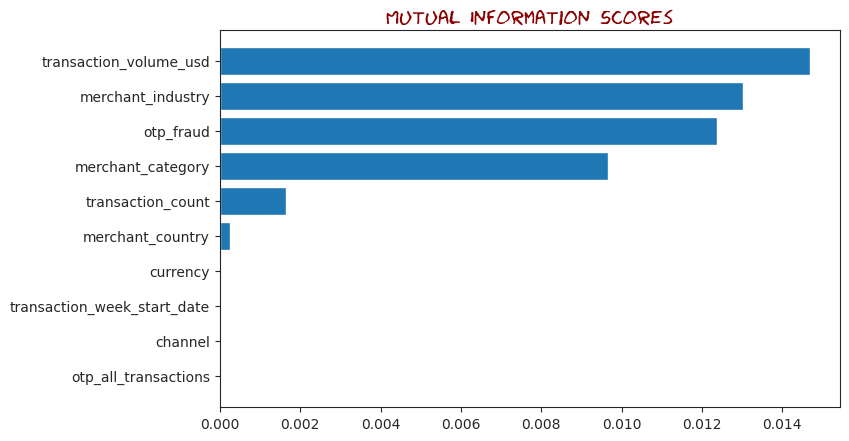

In [31]:
plot_mi_scores(mi_scores)

From the Mutual-Information analysis, we can see the features that are most discriminative to `fraud_count` . Therefore, we can proceed with our analysis focusing on these top features. Let's update the `mi_combined` dataframe to have only these features that tell us something about `fraud-count`.
 

### 3. Selecting Top MI-Scores features:

**Let's select the top features from MI analysis and ofcourse add the `fraud_count` column as our target. This can be used for any machine-learning task.**

In [32]:
# We'd use a threshold of 0.0012 based on the MI chart above.
t = 0.001
top_mi = [ind for ind in list(mi_scores.index) if mi_scores[ind] > t]

In [33]:
# Finally, append target column
top_mi.append('fraud_count')  

In [34]:
top_mi

['transaction_volume_usd',
 'merchant_industry',
 'otp_fraud',
 'merchant_category',
 'transaction_count',
 'fraud_count']

**Now, we re-create the `mi_combined` df but with only the features from MI-analysis**

In [35]:
# Now select only MI-features
mi_combined = combined_df[top_mi]

print(f'MI-combined shape is: {mi_combined.shape}\n')
mi_combined.head(3)

MI-combined shape is: (17418, 6)



,transaction_volume_usd,merchant_industry,otp_fraud,merchant_category,transaction_count,fraud_count
0,231.590551,GOODS-PHYSICAL,0,e-Commerce,5,0
1,210.203412,SERVICES-LEGAL,0,Other,2,0
2,223.097113,TRAVEL,0,Travel & Hospitality,4,0


### 4. Analyzing Weekly Fraud Trends:
#### Trying to identify weeks where Fraud is high to check if there are possible social reasons for that.

In [36]:
june_weeks = list(june_df.transaction_week_start_date.unique())
july_weeks = list(july_df.transaction_week_start_date.unique())

# Let's add these together
june_weeks.extend(july_weeks)

# Let's rename the extension
weekly_dates = june_weeks

**Get the weekly fraud-count and transactions-count...**

In [37]:
# save the weekly dates intuitively for plotting sakes

length = len(weekly_dates)
weekly_index = ['June_W'+str(i) if i <=  length//2 else 'July_W'+str(i-4) for i in range(1, length+1) ]

In [38]:
def get_weekly_data(col, col1='transaction_week_start_date', 
                    kind='sum', name=None, df=combined_df):
    """ Function to get weekly aggregate data

    @param df: dataframe to groupby on
    @param col1 and col2: str cols to groupby and index on
    @param kind: str, kind of operation e.g mean, sum, count
                default=sum
    @param name: str, name of resulting series obj, default=None
    @return: A pandas series object
    """
    kind = kind.lower()
    assert kind in ['sum', 'mean', 'count'],'ERROR:Must be sum, mean or count'

    if kind == 'sum':
        serie = df.groupby([col1])[col].sum()
        serie.index = weekly_index
        serie.name = name

    elif kind == 'mean':
        serie = df.groupby([col1])[col].mean()
        serie.index = weekly_index
        serie.name = name

    else:
        serie = df.groupby([col1])[col].count()
        serie.index = weekly_index
        serie.name = name

    return serie

In [39]:
col = 'fraud_count'
name = 'Weekly Fraud-Count'

weekly_fraud_count = get_weekly_data(col, name=name)
weekly_fraud_count

June_W1    256
June_W2    284
June_W3    182
June_W4    211
July_W1    112
July_W2    109
July_W3     70
July_W4    100
Name: Weekly Fraud-Count, dtype: int64

In [40]:
col = 'transaction_count'
name = 'Weekly Transaction-Count'

weekly_transact_count = get_weekly_data(col, name=name)
weekly_transact_count

June_W1     997735
June_W2    1064033
June_W3    1073565
June_W4    1042017
July_W1    1030233
July_W2     965332
July_W3     978273
July_W4    1015426
Name: Weekly Transaction-Count, dtype: int64

Let's plot the weekly fraud trends...

In [41]:
def plot_weekly_trends(s1, s2, plot='bar', styl=None):
    """Method for plotting weekly fraud data
    """
    plt.figure(figsize=(24,6))
    plt.style.use(styl)
    print(f'style: {styl}')

    plt.subplot(1,2,1)
    plt.plot(s1, color='red')
    plt.xlabel('Week', fontdict=fontDict2)
    plt.ylabel('Count', fontdict=fontDict2)
    plt.title(s1.name, fontdict=fontDict1)

    if plot == 'bar':
        plt.subplot(1,2,2)
        plt.bar(x=s2.index, height=list(s2), color=random.sample(darker_colors, 8))
        plt.title(s2.name, fontdict=fontDict1)
        plt.xlabel('Week', fontdict=fontDict2)
        plt.ylabel('Count', fontdict=fontDict2)
    else:
        plt.subplot(1,2,2)
        plt.plot(s2, color='Red')
        plt.title(s2.name, fontdict=fontDict1)
        plt.xlabel('Week', fontdict=fontDict2)
        plt.ylabel('Count', fontdict=fontDict2)

    plt.show()

style: seaborn-whitegrid


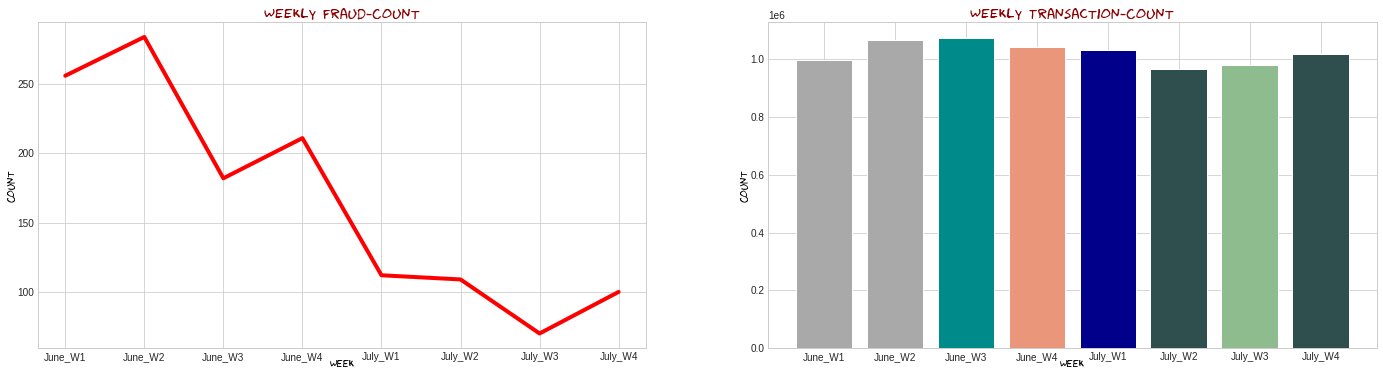

In [42]:
# styl = random.sample(styles, 1)
styl = 'seaborn-whitegrid'
s1 = weekly_fraud_count
s2 = weekly_transact_count

plot_weekly_trends(s1, s2, styl=styl)

From the weekly fraud trend data, we can see that generally, fraud is trending downward. This does not mean it may not trend upward in the future, though, as can be seen in the rise in last week of July.

* Fraud starts high at about 250 for June-Wk-1
* It increases to about 280 for June-Wk-2
* Then it drops to about 180 in June-Wk-3
* Then it rises to about 210 in June-Wk-4
* And just keeps dropping weekly in July, lowest in July-Wk-3
* Starts rising again in July-Wk-4

While the weekly transactions count remain fairly constant between 970k and 1.07 million. Therefore, the data does not support the hypothesis that as fewer transactions are done, fewer fraud tends to be done. This is because the rate of fraud tends to decrease week by week, even though fairly same transactions are done. In otherwords, there's a weak correlation if any between weekly fraud count and weekly transactions count.

Although correlation does not imply cauation, we can see that:-   
* June 14th which marks the start of June-Wk-2 is a national holiday called **democracy-day** in Nigeria
* June 20th is Father's day
* June 23rd is also a regional holiday in Ebonyi State
* Tuesday July 20th and Wednesday July 21st are also public holidays called **id-el-kabir**

[source1](https://www.timeanddate.com/holidays/nigeria/), [source2](https://www.officeholidays.com/countries/nigeria/2021)

### 5. Drilling down on Fraudulent transactions data:

In [43]:
june_fraud_specific = june_df[june_df.fraud_count > 0]
print(f'June Fraud-Specific data shape is: {june_fraud_specific.shape}\n')

june_fraud_specific.head(3)

June Fraud-Specific data shape is: (61, 13)



,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
7,31,SAVINGS,Financial Services,Nigeria,NGN,2021-06-07,card,161803,1.840269e+06,2,0.787402,1,2247
26,114,CORPORATE,Other,Nigeria,NGN,2021-06-07,card,11317,2.271184e+05,1,5.511811,0,3063
34,147,BETTING,Betting,Nigeria,NGN,2021-06-07,card,16415,3.563845e+05,4,539.212598,3,2896


In [44]:
july_fraud_specific = july_df[july_df.fraud_count > 0]
print(f'July Fraud-Specific data shape is: {july_fraud_specific.shape}\n')

july_fraud_specific.head(3)

July Fraud-Specific data shape is: (51, 13)



,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
9,30,SAVINGS,Financial Services,Nigeria,NGN,2021-07-05,card,165099,1.822132e+06,10,1443.832021,1,2294
36,145,LENDING,Financial Services,Nigeria,NGN,2021-07-05,card,16172,3.501336e+05,1,2.650919,0,2786
128,486,BETTING,Betting,Nigeria,NGN,2021-07-05,card,232184,1.784707e+06,62,8424.934383,6,58841


**Let's see the distribution of fraud across `merchant_category` for June and July**

In [45]:
def groupby_to_series(df, col1, col2, kind='Sum', name=None, sort='Desc', norm=True):
    """Method to perform aggregations across a dataframe
        using the groupby method

    @param df: dataframe to groupby on
    @param col1 and col2: str cols to groupby and index on
    @param kind: str, kind of operation e.g mean, sum, count
                default=sum
    @param name: str, name of resulting series obj, default=None
    @return: A pandas series object   
    """
    kind = kind.lower()
    sort = sort.lower()

    assert kind in ['sum', 'mean', 'count'],'ERROR:Must be sum, mean or count'
    assert sort in ['desc', 'asc'],'ERROR:Must be Asc or Desc'

    if kind == 'sum':
        serie = df.groupby([col1])[col2].sum()

    if sort == 'desc':
        serie.sort_values(ascending=False, inplace=True)
    else:
        serie.sort_values(inplace=True)

    if norm:
        serie = 100*serie / serie.sum()
    serie.name = name

    return serie

In [46]:
col1 = 'merchant_category'
col2 = 'fraud_count'
name = 'Merchant-Category Fraud: June'

june_merchant_cat_fraud = groupby_to_series(june_fraud_specific, col1, col2, name=name)
june_merchant_cat_fraud

merchant_category
Betting                  80.814577
Financial Services       17.363344
Digital Services          0.643087
Other                     0.428725
Utilities                 0.321543
Media & Entertainment     0.214362
e-Commerce                0.107181
Education                 0.107181
Name: Merchant-Category Fraud: June, dtype: float64

In [47]:
name = 'Merchant-Category Fraud: July'

july_merchant_cat_fraud = groupby_to_series(july_fraud_specific, col1, col2, name=name)
july_merchant_cat_fraud

merchant_category
Financial Services      52.429668
Betting                 42.710997
e-Commerce               2.301790
Education                1.023018
Utilities                0.767263
Other                    0.511509
Travel & Hospitality     0.255754
Name: Merchant-Category Fraud: July, dtype: float64

**Let's visualize the top 5 merchant categories for fraudulent transactions**

In [48]:
def compare_pie_chart(sup_title, titles, s1, s2, size, colours):
    """Pie chart to compare values for June and July
    
    @param suptitle: Str, summary title of the plot
    @param titles: List of string sub-titles per plot
    @param s1: first series object
    @param s2: second series object
    @param size: A tuple of figure size
    @param colours: A List of colors for the piecharts
    """
    plt.figure(figsize=size)
    sns.set(font_scale=1.2)
    sns.set_style('ticks')
    plt.suptitle(sup_title, y=1.05)

    # For the first plot
    plt.subplot(121)
    plt.pie(s1, 
       autopct='%1.1f%%',
       colors=colours,
       startangle=90,
       shadow=True,
       pctdistance=1.06)
    plt.title(titles[0], y=1.05, fontdict=fontDict1)
    plt.axis('equal')
    plt.legend(labels=s1.index, loc='upper right')

    # For the second plot
    plt.subplot(122)
    plt.pie(s2, 
       autopct='%1.1f%%',
       colors=colours,
       startangle=90,
       shadow=True,
       pctdistance=1.06)
    plt.title(titles[1], y=1.05, fontdict=fontDict1)
    plt.axis('equal')
    plt.legend(labels=s2.index, loc='upper right')

    plt.show()

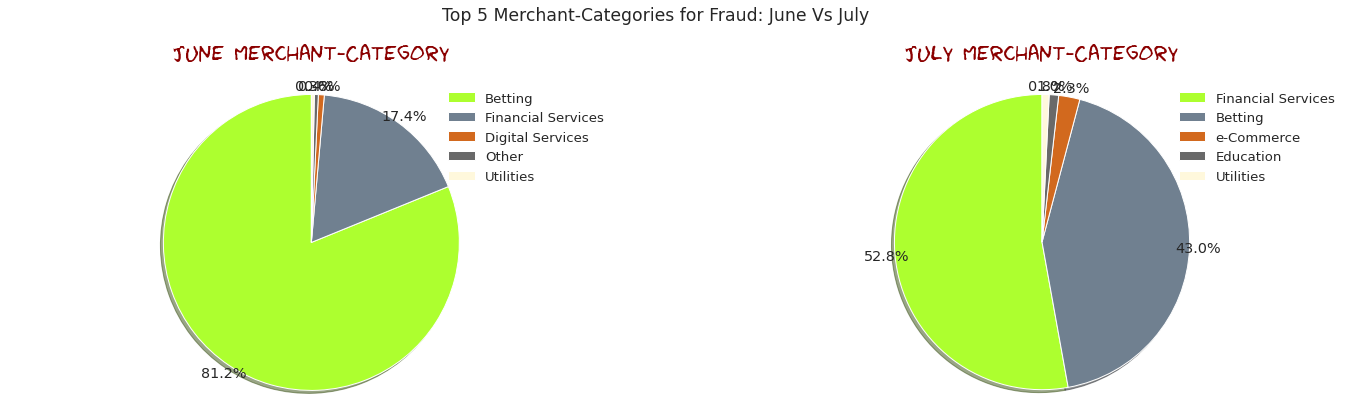

In [49]:
sup_title = 'Top 5 Merchant-Categories for Fraud: June Vs July'
titles = ['June Merchant-Category', 'July Merchant-Category']
s1 = june_merchant_cat_fraud[:5]
s2 = july_merchant_cat_fraud[:5]
colours = random.sample(other_colors, len(s1))
size = (24, 6)

compare_pie_chart(sup_title, titles, s1, s2, size, colours)

We can see that two merchant-categories make up more than 98% of total fraud. These are
1. Betting
2. Financial services

**Let's see the distribution of fraud across `merchant_industry` for June and July**

In [50]:
col1 = 'merchant_industry'
col2 = 'fraud_count'
name = 'Merchant-Industry Fraud: June'

june_merchant_ind_fraud = groupby_to_series(june_fraud_specific, col1, col2, name=name)

In [51]:
name = 'Merchant-Industry Fraud: July'

july_merchant_ind_fraud = groupby_to_series(july_fraud_specific, col1, col2, name=name)

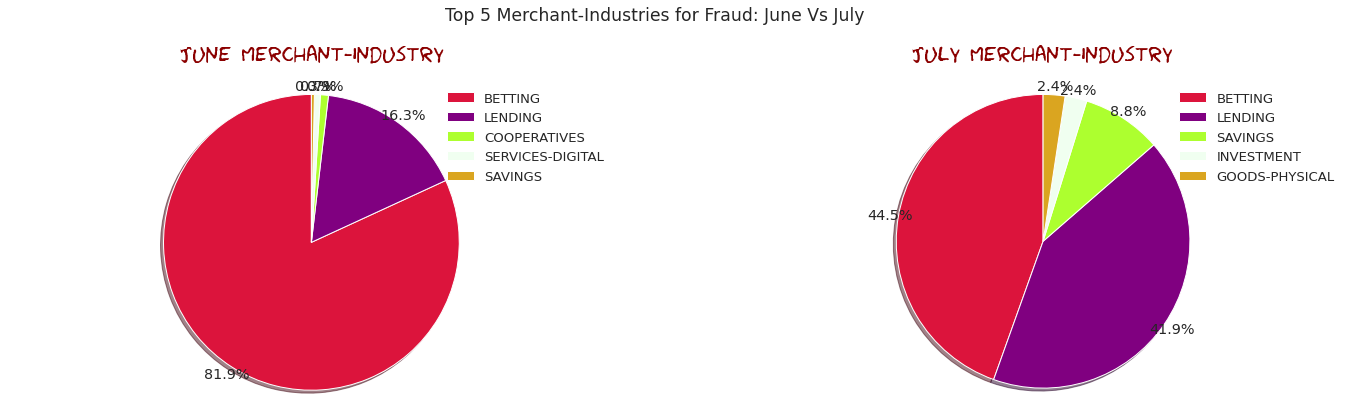

In [52]:
sup_title = 'Top 5 Merchant-Industries for Fraud: June Vs July'
titles = ['June Merchant-Industry', 'July Merchant-Industry']
s1 = june_merchant_ind_fraud[:5]
s2 = july_merchant_ind_fraud[:5]
colours = random.sample(other_colors, len(s1))
size = (24, 6)

compare_pie_chart(sup_title, titles, s1, s2, size, colours)

From the two sets of Piecharts above, we can surmise that...<br>
Merchants in the **Betting** and **Financial Services** category, who operate within the **Betting** and **Lending** industries recorded more than 98% of total frauds across merchant-categories and more than 96% of total fraud across merchant-industries, for the months of June and July 2021.

**The next step is to identify these merchants...**

So, we want to select merchants in the Betting and Financial-Services(FS) categories that operate within the Betting and Lending industries.

In [53]:
# First, we select Merchants whose category is either FS or Betting
high_risk = combined_df[(combined_df.merchant_category == 'Betting') \
                                    | (combined_df.merchant_category == 'Financial Services')]

# Then from these, we select those whose industries are BETTING or LENDING
high_risk = high_risk[(high_risk.merchant_industry == 'BETTING') \
                                              | (high_risk.merchant_industry == 'LENDING')]

# We do it this way, just incase BETTING and LENDING industries also exist in 
# other marchant-categories aside from Betting and Financial-Services.

print(f'High-Risk Merchants shape is: {high_risk.shape}\n', end=' ')
high_risk.head()

High-Risk Merchants shape is: (1521, 13)
 

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
27,118,LENDING,Financial Services,Nigeria,NGN,2021-06-07,card,2511,30218.315853,0,0.000000,0,579
29,126,BETTING,Betting,Nigeria,NGN,2021-06-07,card,2,19.685039,0,0.000000,0,1
34,147,BETTING,Betting,Nigeria,NGN,2021-06-07,card,16415,356384.474199,4,539.212598,3,2896
37,158,LENDING,Financial Services,Nigeria,NGN,2021-06-07,card,1,0.026247,0,0.000000,0,1
50,216,BETTING,Betting,Nigeria,NGN,2021-06-07,card,81,1005.225696,0,0.000000,0,58


**Since we've identified them, let's also separate the others**

In [54]:
others_index = list(set(list(combined_df.index)) - set(list(high_risk.index)))
(len(others_index) + len(high_risk.index)) == len(combined_df.index)

True

In [55]:
others = combined_df.iloc[others_index, :]
print(len(others_index) == len(others))
print(f'others shape: {others.shape}\n')
others.head(3)

True
others shape: (15897, 13)



,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-06-07,card,5,231.590551,0,0.0,0,5
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-06-07,card,2,210.203412,0,0.0,0,2
2,9,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-06-07,card,4,223.097113,0,0.0,0,1


**Let's see the actual split of distinct merchants in the High-Risk industries and other industries.**

In [56]:
num_high_risk_merchants = high_risk.merchant_id.nunique()
num_other_merchants = others.merchant_id.nunique()

print(f'High-Risk Merchants are: {num_high_risk_merchants}\nWhile others are {num_other_merchants} in total.')

High-Risk Merchants are: 500
While others are 5740 in total.


In [57]:
def plot_merchants_split(names, val1, val2, size, sup_title, color=colours, loc='upper right'):
    """Function to plot the split of merchants
        across High-Risk and low-Risk bounds.

    @param names: A list of string names
    @param val1 & val2: Integer values
    @param size: A tuple of figure size dimensions
    @param sup_title: String, the overall suptitle of both charts
    """

    plt.figure(figsize=size)
    total = val1 + val2

    s1 = pd.Series([val1, val2], index=names, 
                       name=titles[0])
    s2 = pd.Series([(val1 / total)*100, (val2 / total)*100], index=names,
                       name=titles[1])
    
    plt.suptitle(sup_title, y=1.05, fontdict=fontDict1)
    
    plt.subplot(1,2,1)
    plt.bar(x=s1.index, height=list(s1), color=colours)
    plt.xlabel('Merchant', fontdict=fontDict2)
    plt.ylabel('Count', fontdict=fontDict2)
    plt.title(s1.name, fontdict=fontDict2)

    plt.subplot(1,2,2)
    plt.pie(s2, 
       autopct='%1.1f%%',
       startangle=90,
       colors=colours,
       shadow=True,
       pctdistance=1.06)
    plt.title(s2.name, fontdict=fontDict2)
    plt.axis('equal')
    plt.legend(labels=s2.index, loc=loc)
 
    plt.show()

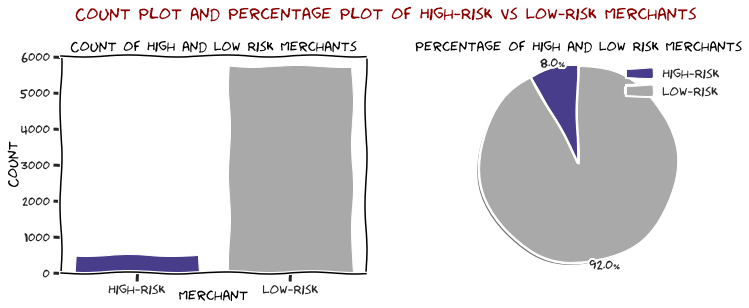

In [58]:
names = ['High-Risk', 'Low-Risk']
titles = ['Count of High and Low Risk Merchants', 'Percentage of High and Low Risk Merchants']
val1, val2 = num_high_risk_merchants, num_other_merchants
sup_title = 'Count Plot and Percentage Plot of High-Risk vs Low-Risk Merchants'
colours = random.sample(darker_colors, 2)
size=(12, 4)
plt.xkcd() # use xkcd style for this plot

plot_merchants_split(names, val1, val2, size, sup_title)

From these charts, we can see that only 8% of Merchants constitute about 98% of fraud transactions. We need to take a much closer look at how these merchants conduct their day-to-day activities.

### 6. Finding Distinct Patterns of High-Risk Merchants

What are the common patterns among merchants who record the most fraud? For example: 
* What's the average transactions volume per week for high-risk merchants and others? 
* Is there a correlation between fraud-count and transaction-count when compared to high-risk and other merchants? 


**Let's see the descriptive statistics for these `High-Risk` merchants**

In [59]:
# Let's see for Categorical Variables of High-Risk merchants

high_risk.describe(include='object').T

,count,unique,top,freq
merchant_industry,1521,2,LENDING,973
merchant_category,1521,2,Financial Services,973
merchant_country,1521,1,Nigeria,1521
currency,1521,1,NGN,1521
transaction_week_start_date,1521,8,2021-06-28,198
channel,1521,1,card,1521


In [60]:
# Let's see for Categorical Variables of other merchants

others.describe(include='object').T

,count,unique,top,freq
merchant_industry,15897,61,GOODS-PHYSICAL,2714
merchant_category,15897,11,Digital Services,3035
merchant_country,15897,3,Nigeria,15840
currency,15897,4,NGN,15763
transaction_week_start_date,15897,8,2021-07-26,2082
channel,15897,1,card,15897


In [61]:
# Let's see for Numerical Variables of High-Risk merchants

high_risk.describe().T

,count,mean,std,min,25%,50%,75%,max
merchant_id,1521.0,4529.500329,2440.657734,65.000000,2520.000000,4571.000000,6835.000000,8.776000e+03
transaction_count,1521.0,3538.559500,23489.974503,1.000000,4.000000,26.000000,379.000000,2.758660e+05
transaction_volume_usd,1521.0,32272.061795,159843.601025,0.000131,19.181102,254.397559,3792.478163,2.271810e+06
fraud_count,1521.0,0.807364,7.982570,0.000000,0.000000,0.000000,0.000000,1.700000e+02
fraud_volume_usd,1521.0,102.467606,1082.253882,0.000000,0.000000,0.000000,0.000000,2.017848e+04
otp_fraud,1521.0,0.077581,0.733971,0.000000,0.000000,0.000000,0.000000,1.700000e+01
otp_all_transactions,1521.0,994.812623,9014.567615,0.000000,2.000000,17.000000,230.000000,2.015910e+05


In [62]:
# Let's see for Numerical Variables of other merchants

others.describe().T

,count,mean,std,min,25%,50%,75%,max
merchant_id,15897.0,4337.852740,2521.710303,1.000000,2156.000000,4340.000000,6489.000000,8.809000e+03
transaction_count,15897.0,175.156633,3775.687452,1.000000,1.000000,2.000000,9.000000,1.716440e+05
transaction_volume_usd,15897.0,4281.138742,52743.628819,0.000026,8.764698,39.370079,194.225722,2.444412e+06
fraud_count,15897.0,0.006039,0.192888,0.000000,0.000000,0.000000,0.000000,1.500000e+01
fraud_volume_usd,15897.0,1.374160,71.472388,0.000000,0.000000,0.000000,0.000000,6.430446e+03
otp_fraud,15897.0,0.001447,0.073966,0.000000,0.000000,0.000000,0.000000,8.000000e+00
otp_all_transactions,15897.0,35.779329,237.725621,0.000000,1.000000,2.000000,7.000000,6.980000e+03


From the describtive stats above, we can see that...
* High-Risk merchants on average performed 3538 transactions within these two months, whie other merchants did an average of 175 transactions.
* High-Risk merchants in the Betting and Lending business did an average of `$32k` USD for these two months. Others did an average of `$4.2k` USD.

* **What's the average transactions count per week for high-risk merchants and others?** 

In [63]:
high_risk.head(2)

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
27,118,LENDING,Financial Services,Nigeria,NGN,2021-06-07,card,2511,30218.315853,0,0.0,0,579
29,126,BETTING,Betting,Nigeria,NGN,2021-06-07,card,2,19.685039,0,0.0,0,1


In [64]:
col = 'transaction_count'
kind = 'Mean'

ave_weekly_high = get_weekly_data(col, kind=kind, df=high_risk, name='High_Risk')
ave_weekly_others = get_weekly_data(col, kind=kind, df=others, name = 'Low_Risk')

# Let's combine these Series objects to a DataFrame for plotting
ave_weekly_trans_df = pd.DataFrame([ave_weekly_high, ave_weekly_others]).T
ave_weekly_trans_df

,High_Risk,Low_Risk
June_W1,3559.687500,162.752460
June_W2,3976.813187,177.215104
June_W3,3685.256545,190.459042
June_W4,3392.797980,180.254625
July_W1,3720.910053,164.394671
July_W2,3303.219251,173.728136
July_W3,3351.684211,172.538151
July_W4,3341.026042,179.610471


In [65]:
print(f'On a weekly average, High-Risk merchants do {round(ave_weekly_trans_df.High_Risk.mean())}, while others do {round(ave_weekly_trans_df.Low_Risk.mean())} transactions.')

On a weekly average, High-Risk merchants do 3541, while others do 175 transactions.


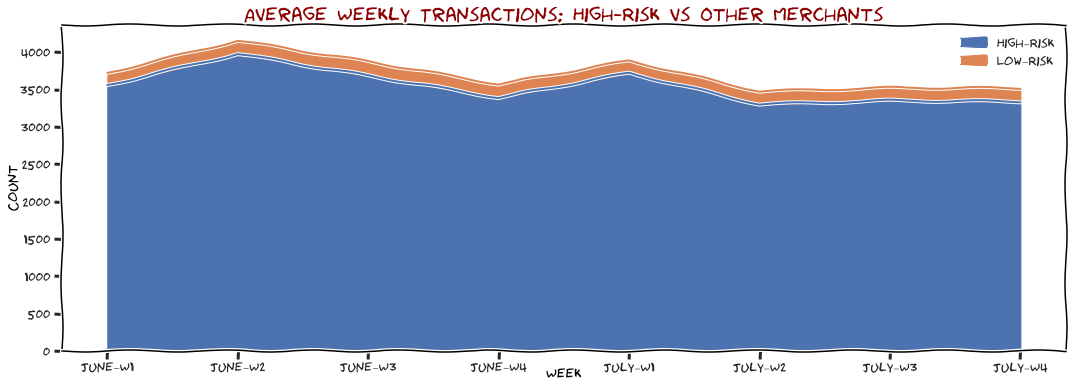

In [66]:
ave_weekly_trans_df.plot(kind='area', figsize=(18,6))
plt.title('Average Weekly Transactions: High-Risk vs Other Merchants', fontdict=fontDict1)

plt.xlabel('Week', fontdict=fontDict2)
plt.ylabel('Count', fontdict=fontDict2)
plt.show()

### 7. Feature-Engineering:

As we prepare to use our data for Machine-Learning activities, we need to prepare the data accordingly by performing certain activities


In [67]:
# First, make a copy of the mi_combined df

copy_mi = mi_combined.copy(deep=True)

In [68]:
copy_mi.head(3)

,transaction_volume_usd,merchant_industry,otp_fraud,merchant_category,transaction_count,fraud_count
0,231.590551,GOODS-PHYSICAL,0,e-Commerce,5,0
1,210.203412,SERVICES-LEGAL,0,Other,2,0
2,223.097113,TRAVEL,0,Travel & Hospitality,4,0


In [69]:
def plot_hist(df):
    
    plt.figure(figsize=size)
    num_cols = list(df.select_dtypes(include='number').columns)
        
    df[num_cols].hist(figsize=size,
                     linewidth=3,
                     edgecolor='black',
                     color=color,
                     density=True)
    
    plt.suptitle(sup_title, fontdict=fontDict1, y=0.95)
    plt.show()

In [70]:
plt.rcdefaults() # to stop xkcd
set_rcParams()

rcParams set!


<Figure size 1500x500 with 0 Axes>

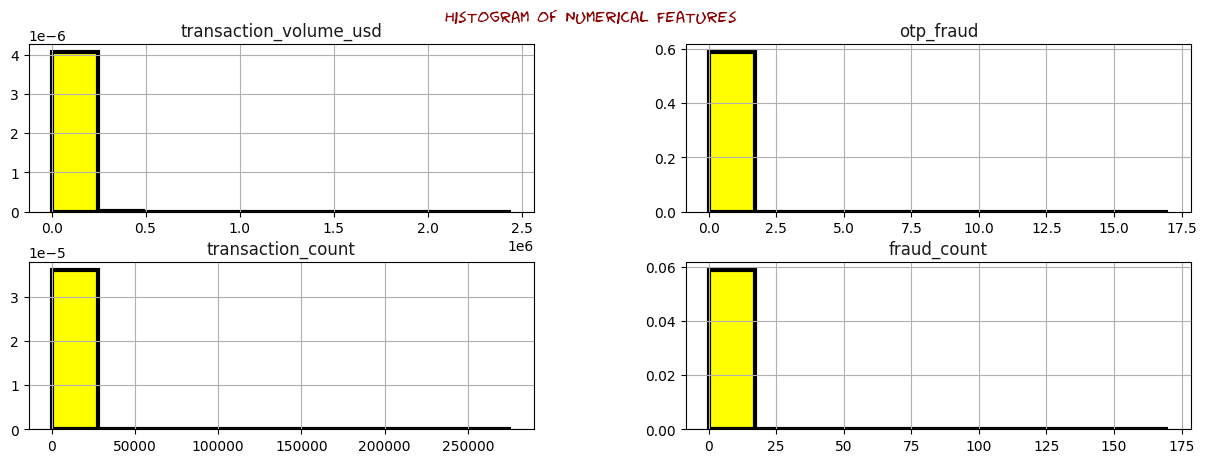

In [71]:
size=(15,5)
color = 'yellow'
sup_title = 'Histogram of Numerical Features'
plot_hist(copy_mi)

In [72]:
top_mi

['transaction_volume_usd',
 'merchant_industry',
 'otp_fraud',
 'merchant_category',
 'transaction_count',
 'fraud_count']

**Checking for outliers**

In [73]:
num_cols = list(copy_mi.select_dtypes(include='number').columns)
cat_cols = list(copy_mi.select_dtypes(exclude='number'))

In [74]:
def find_extreme_boundaries(variable, df, distance=3):
    """This method computes and returns the upper
        and lower outlier boundaries for each variable.
    """

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    if upper_boundary == lower_boundary:
        upper_boundary = max(df[variable])
        lower_boundary = min(df[variable])

    return upper_boundary, lower_boundary

**Let's see the extreme outliers in the numerical columns**

In [75]:
def extreme_outliers_toDF(df, cols):
    """This method computes the outliers
    in a dataframe and returns these values as a
    dataframe 

    @param df: A dataframe
    @param distance: The limit of outlier, max & default=3
    """
    outliers_dict = {}
    for col in cols:
        upper, lower = find_extreme_boundaries(col,df)
        outliers = np.where(df[col] > upper, True,
        np.where(df[col] < lower, True, False))
        count_outliers = np.sum(outliers)
        outliers_dict[col] = [count_outliers]
    
    outliers_df = pd.DataFrame(outliers_dict).T
    outliers_df.columns = ['count']
    return outliers_df

In [76]:
ext_outliers_df = extreme_outliers_toDF(copy_mi, num_cols)
ext_outliers_df

,count
transaction_volume_usd,2317
otp_fraud,0
transaction_count,2154
fraud_count,0


**let's clip outliers to lower or max values**

In [77]:
def clip_extreme_outliers(main_df, sub_df):
    """Function clips extreme outliers

    @param df: a dataframe
    @param cols: list of columns to clip from
    """
    indx = list(sub_df.index)

    for ind in indx:
        if sub_df.at[ind, 'count'] > 100:
            high, low = find_extreme_boundaries(ind, main_df)
            print(ind,':', high, low)
            main_df[ind] = np.where(main_df[ind] > high, high,
                           np.where(main_df[ind] < low, low, main_df[ind]))
    return main_df

In [78]:
# Let's clip the extreme outliers
copy_mi = clip_extreme_outliers(copy_mi, ext_outliers_df)
print('done!')

transaction_volume_usd : 917.3228346456658 -671.9160104986851
transaction_count : 45.0 -32.0
done!


In [79]:
# Check for extreme outliers
extreme_outliers_toDF(copy_mi, num_cols)

,count
transaction_volume_usd,0
otp_fraud,0
transaction_count,0
fraud_count,0


**Normalizing Numeric data with Quantization and log-transform based on the shape of the distribution**

All aside from `merchant_id` will be normalized with log_transform

In [80]:
# Let's check if any missing or NaA values by chance

copy_mi.isna().any()

transaction_volume_usd    False
merchant_industry         False
otp_fraud                 False
merchant_category         False
transaction_count         False
fraud_count               False
dtype: bool

In [81]:
copy_mi.head()

,transaction_volume_usd,merchant_industry,otp_fraud,merchant_category,transaction_count,fraud_count
0,231.590551,GOODS-PHYSICAL,0,e-Commerce,5.0,0
1,210.203412,SERVICES-LEGAL,0,Other,2.0,0
2,223.097113,TRAVEL,0,Travel & Hospitality,4.0,0
3,212.335958,SERVICES-PROFESSIONAL,0,Other,5.0,0
4,550.131234,SERVICES-DIGITAL,0,Digital Services,8.0,0


<Figure size 1500x500 with 0 Axes>

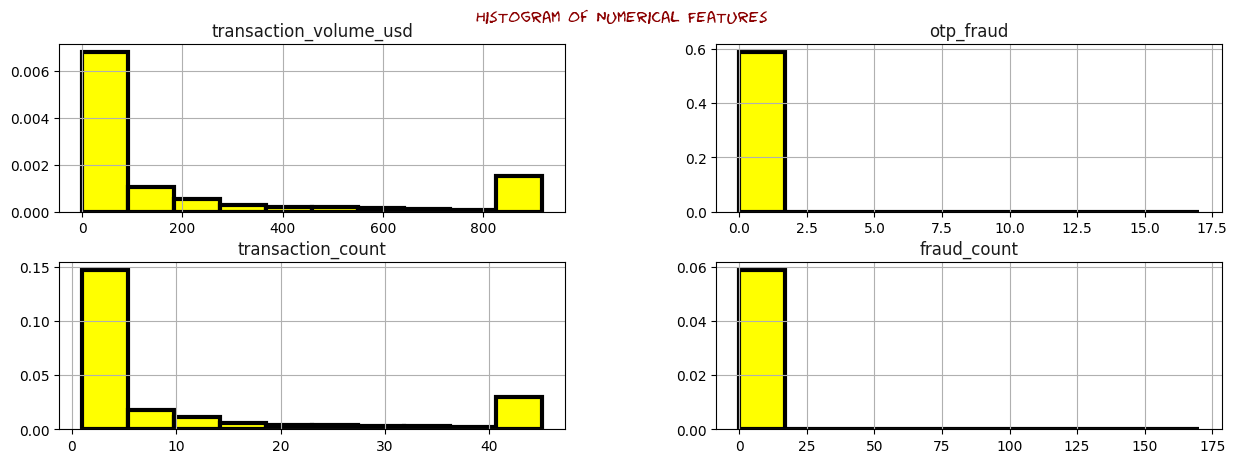

In [82]:
# Let's see the numeric features again

plot_hist(copy_mi)

**From the data, we'd normalize the following columns if they are present `otp_all_transactions` and `otp_fraud` and `fraud_count` with log-transform, while the rest will be quantization** 

In [83]:
def log_transform(df, cols):
    for col in cols:
        data = df[col].astype('float').values
        # avoid division by zero issues
        data = np.log(data, out=data, where=data > 0.0000000001)
        df[col] = list(data)
    print('done!')

In [84]:
col_quant = ['otp_all_transactions', 'transaction_volume_usd', 'transaction_count']
col_log = [col for col in num_cols if col not in col_quant]

# Now apply the log-transformation
log_transform(copy_mi, col_log)

done!


In [85]:
copy_mi.isna().any()

transaction_volume_usd    False
merchant_industry         False
otp_fraud                 False
merchant_category         False
transaction_count         False
fraud_count               False
dtype: bool

In [86]:
numQuantiles = 20
colsQuantiles = col_quant

def createQuantiles(dfColumn, numQuantiles):
  return pd.qcut(dfColumn, numQuantiles, labels=False, duplicates='drop')

# Now we quantize the features
for string in colsQuantiles:
    if string in num_cols:
        copy_mi[string] = createQuantiles(copy_mi[string], numQuantiles)
print('done!')

done!


In [87]:
# check for missing values

copy_mi.isna().any()

transaction_volume_usd    False
merchant_industry         False
otp_fraud                 False
merchant_category         False
transaction_count         False
fraud_count               False
dtype: bool

In [88]:
def minMaxScaler(numArr):
  minx = np.min(numArr)
  maxx = np.max(numArr)
  numArr = (numArr - minx) / (maxx - minx)
  return numArr

In [89]:
# Now, scale the numeric columns

for string in num_cols:
  copy_mi[string] = minMaxScaler(copy_mi[string])
print('done!')

done!


In [90]:
copy_mi.isna().any()

transaction_volume_usd    False
merchant_industry         False
otp_fraud                 False
merchant_category         False
transaction_count         False
fraud_count               False
dtype: bool

<Figure size 1500x500 with 0 Axes>

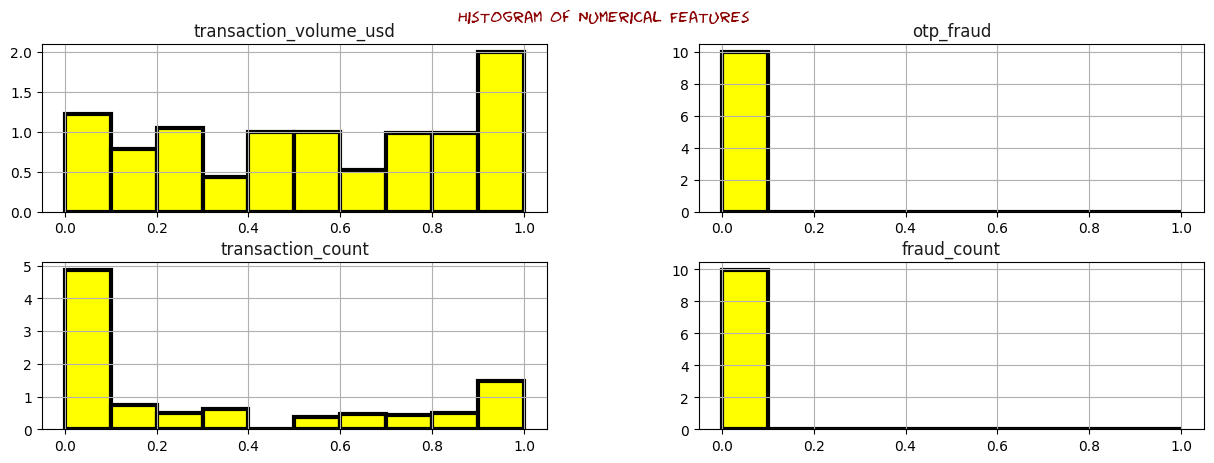

In [91]:
plot_hist(copy_mi)

In [92]:
copy_mi.head()

,transaction_volume_usd,merchant_industry,otp_fraud,merchant_category,transaction_count,fraud_count
0,0.823529,GOODS-PHYSICAL,0.0,e-Commerce,0.375,0.0
1,0.823529,SERVICES-LEGAL,0.0,Other,0.000,0.0
2,0.823529,TRAVEL,0.0,Travel & Hospitality,0.250,0.0
3,0.823529,SERVICES-PROFESSIONAL,0.0,Other,0.375,0.0
4,0.941176,SERVICES-DIGITAL,0.0,Digital Services,0.500,0.0


**Encoding Categorical variables**

We may choose either to one-hot-encode these or merely discretize them numnerically using the factorize() function.

In [93]:
cat_cols = list(copy_mi.select_dtypes(exclude='number'))
cat_cols

['merchant_industry', 'merchant_category']

In [94]:
# Let's encode and scale the categorical columns same time

for cat in cat_cols:
    copy_mi[cat], _ = copy_mi[cat].factorize()
    copy_mi[cat] = minMaxScaler(copy_mi[cat])
print('done!')

done!


In [95]:
# Check for mising values

copy_mi.isna().any()

transaction_volume_usd    False
merchant_industry         False
otp_fraud                 False
merchant_category         False
transaction_count         False
fraud_count               False
dtype: bool

In [96]:
copy_mi.head()

,transaction_volume_usd,merchant_industry,otp_fraud,merchant_category,transaction_count,fraud_count
0,0.823529,0.000000,0.0,0.0,0.375,0.0
1,0.823529,0.016129,0.0,0.1,0.000,0.0
2,0.823529,0.032258,0.0,0.2,0.250,0.0
3,0.823529,0.048387,0.0,0.1,0.375,0.0
4,0.941176,0.064516,0.0,0.3,0.500,0.0


### 8. Applying Clustering Machine Learning Algorithm: K-Means

Centroid-based(CB) clustering are easier to use and interpret than density-based(DB) clustering. Although CB is susceptible to outliers and even clusters outliers, while DB is resistant to outliers. But we have already dealt with our extreme outliers.

**Therefore, let's define some helper methods for K-means algorithm**

In [97]:
import math
import numpy.linalg as nla
import altair as alt
import re
import pdb  # for Python debugger
import sys
from os.path import join

In [98]:
def dfSimilarity(df, centroids):
    """Calculate similarities for dataframe input.
        We use the Euclidean Distance calculation

    We need to calculate np.sqrt(||a-b||^2 = |a|^2 + |b|^2 - 2*|a|*|b|),
    and do so using matrix operations

    @param df: a dataframe, shape(m, n)
    @param centroids: subset of df, shape(k, n), 
                     where k is cluster size
    @return: An array of similarity scores
    """
    numPoints = len(df.index)
    numCentroids = len(centroids.index)

    ## Strictly speaking, we don't need to calculate the norm of points
    # because it adds a constant bias to distances
    # But calculating it so that the similarity doesn't go negative
    # And that we expect similarities in [0,1] which aids debugging

    # find the dot-product of each row or observation in df
    pointNorms = np.square(nla.norm(df, axis=1))
    # reshape the 1D array of dot-products to a column array
    pointNorms = np.reshape(pointNorms, [numPoints, 1])

    # # find the dot-product of each row or observation in centroids
    centroidNorms = np.square(nla.norm(centroids, axis=1))
    # reshape the 1D array of dot-products to a row array
    centroidNorms = np.reshape(centroidNorms, (1, numCentroids))

    ## Calculate |a|^2 + |b|^2 - 2*|a|*|b|
    similarities = pointNorms + centroidNorms - 2.0 * np.dot(
        df, np.transpose(centroids))
    
    # Divide by the number of feature directly if no OHE-features,
    # Else divide by original feature size if OHE
    similarities = similarities / df.shape[1]

    # numerical artifacts lead to negligible but negative values 
    # that go to NaN on the root, so let's clip such features
    similarities = similarities.clip(min=0.0)

    # Square root since it's ||a-b||^2
    similarities = np.sqrt(similarities)
    return similarities

In [99]:
def initCentroids(df, k, feature_cols):
    """Helper function to initialize centroids randomly

    @param df: a preprocesed dataframe for k-means
    @param k: An integer for number of clusters/centroids
    @param feature_cols: an array of string feature names for k-means
    @return: dataframe of centroids(sliced from df size(k, len(feature_cols)))
    """
    limit = len(df.index)
    centroids_key = np.random.randint(0, limit - 1, k)
    centroids = df.loc[centroids_key, feature_cols].copy(deep=True)
    # the indexes get copied over so reset them
    centroids.reset_index(drop=True, inplace=True)
    return centroids

In [100]:
def pt2centroid(df, centroids, feature_cols):
    """Helper function to calculate similarities between 
    all points and centroids, Assign points to the 
    closest centroids and save that distance.

    @param df: a dataframe, shape(m, n)
    @param centroids: subset of df, shape(k, n), 
                     where k is cluster size
    @param feature_cols: an array of string feature names for k-means
    @return: df with centroid and pt2centroid columns data
    """
    numCentroids = len(centroids.index)
    numExamples = len(df.index)

    # dfSimilarity = Calculate similarities for dataframe input
    dist = dfSimilarity(df.loc[:, feature_cols], centroids.loc[:, feature_cols])
    df.loc[:, 'centroid'] = np.argmin(dist, axis=1)  # closest centroid
    df.loc[:, 'pt2centroid'] = np.min(dist, axis=1)  # minimum distance
    return df

In [101]:
def recomputeCentroids(df, centroids, feature_cols):
    """Helper function to recompute centroids.
        Thus, for every centroid, recompute it as an
        average of the points assigned to it.

    @param df: a preprocesed dataframe for k-means
    @param feature_cols: an array of string feature names for k-means
    @param centroids: dataframe of centroids(sliced from df size(k, len(feature_cols)))
    """
  
    numCentroids = len(centroids.index)
    for cen in range(numCentroids):
        dfSubset = df.loc[df['centroid'] == cen,
                            feature_cols]  # all points for centroid
    if not (dfSubset.empty):  # if there are points assigned to the centroid
        clusterAvg = np.sum(dfSubset) / len(dfSubset.index)
        centroids.loc[cen] = clusterAvg
    return centroids

**Finally, we put all the helper functions together in the kmeans function below**

In [102]:
def kmeans(df, k, feature_cols, verbose, max_iter=100):
    flagConvergence = False
    maxIter = max_iter
    iter = 0  # initialize counter to 0

    centroids = initCentroids(df, k, feature_cols)
    while not (flagConvergence):
        iter += 1
        #Save old mapping of points to centroids
        oldMapping = df['centroid'].copy(deep=True)

        # Perform k-means
        df = pt2centroid(df, centroids, feature_cols)
        centroids = recomputeCentroids(df, centroids, feature_cols)

        # Check convergence by comparing [oldMapping, newMapping]
        newMapping = df['centroid']
        flagConvergence = all(oldMapping == newMapping)
        if verbose == 1:
            print('Total distance:' + str(np.sum(df['pt2centroid'])))
        if (iter > maxIter):
            print('k-means did not converge! Reached maximum iteration limit of ' \
                + str(maxIter) + '.')
            sys.exit()
            return
    print('k-means converged for ' + str(k) + ' clusters' + \
        ' after ' + str(iter) + ' iterations!')
    return df, centroids

**Find optimal number of clusters**

In [103]:
initial_k = 100  # set k to something high

feature_cols = copy_mi.columns.values  # save column values as a numpy array

# initialize every point to an impossible value, the k+1 cluster
copy_mi['centroid'] = initial_k + 1

# init the point to centroid distance to an impossible value "5" (>1)
copy_mi['pt2centroid'] = 5

# Let's see the new columns
copy_mi.head()

,transaction_volume_usd,merchant_industry,otp_fraud,merchant_category,transaction_count,fraud_count,centroid,pt2centroid
0,0.823529,0.000000,0.0,0.0,0.375,0.0,101,5
1,0.823529,0.016129,0.0,0.1,0.000,0.0,101,5
2,0.823529,0.032258,0.0,0.2,0.250,0.0,101,5
3,0.823529,0.048387,0.0,0.1,0.375,0.0,101,5
4,0.941176,0.064516,0.0,0.3,0.500,0.0,101,5


k-means converged for 4 clusters after 8 iterations!
k-means converged for 6 clusters after 8 iterations!
k-means converged for 8 clusters after 11 iterations!
k-means converged for 10 clusters after 10 iterations!
k-means converged for 12 clusters after 8 iterations!
k-means converged for 14 clusters after 15 iterations!
k-means converged for 16 clusters after 15 iterations!
k-means converged for 18 clusters after 12 iterations!
k-means converged for 20 clusters after 11 iterations!
k-means converged for 22 clusters after 15 iterations!
k-means converged for 24 clusters after 18 iterations!
k-means converged for 26 clusters after 6 iterations!
k-means converged for 28 clusters after 9 iterations!
k-means converged for 30 clusters after 18 iterations!
k-means converged for 32 clusters after 16 iterations!
k-means converged for 34 clusters after 11 iterations!
k-means converged for 36 clusters after 31 iterations!
k-means converged for 38 clusters after 14 iterations!
k-means converged 

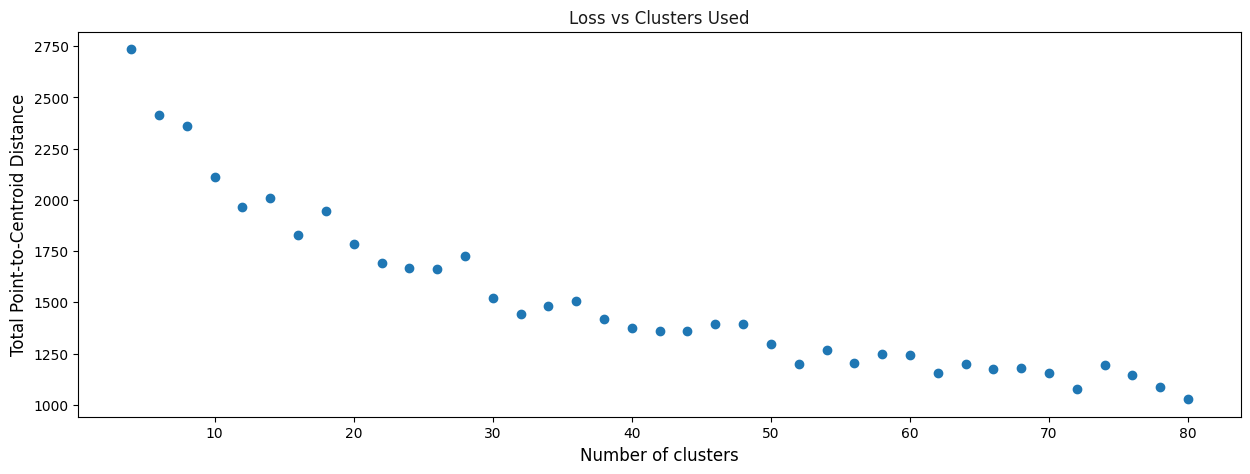

In [104]:
# Plot loss vs number of clusters
copy_mi2 = copy_mi.copy(deep=True)

def lossVsClusters(kmin, kmax, kstep, copy_mi2):
    kmax += 1  # include kmax-th cluster in range
    kRange = range(kmin, kmax, kstep)
    loss = np.zeros(len(kRange))
    lossCtr = 0

    for kk in kRange:
        [copy_mi2, centroids] = kmeans(copy_mi2, kk, feature_cols, 0)
        loss[lossCtr] = np.sum(copy_mi2['pt2centroid'])
        lossCtr += 1
    plt.figure(figsize=size)
    plt.scatter(kRange, loss)
    plt.title('Loss vs Clusters Used')
    plt.xlabel('Number of clusters')
    plt.ylabel('Total Point-to-Centroid Distance')


kmin =   4# @param
kmax = 80  # @param
kstep =   2# @param
lossVsClusters(kmin, kmax, kstep, copy_mi2)

**Let's now run K-means**

From the optimal clusters, I'd choose `k = 42`

In [105]:
# Run the K-means query
k = 42
copy_mi, centroids = kmeans(copy_mi, k, feature_cols, verbose=1)

print("Data for the first few rows, with 'centroid' and 'pt2centroid' on"
      ' the extreme right:\n')
copy_mi.head()

Total distance:1453.555781987693
Total distance:1452.2925364039002
Total distance:1447.1821312703462
Total distance:1428.2630670348244
Total distance:1423.7442611959868
Total distance:1423.649904172516
Total distance:1423.652880762206
Total distance:1423.665466516391
k-means converged for 42 clusters after 8 iterations!
Data for the first few rows, with 'centroid' and 'pt2centroid' on the extreme right:



,transaction_volume_usd,merchant_industry,otp_fraud,merchant_category,transaction_count,fraud_count,centroid,pt2centroid
0,0.823529,0.000000,0.0,0.0,0.375,0.0,27,0.048029
1,0.823529,0.016129,0.0,0.1,0.000,0.0,16,0.047820
2,0.823529,0.032258,0.0,0.2,0.250,0.0,23,0.095639
3,0.823529,0.048387,0.0,0.1,0.375,0.0,27,0.066058
4,0.941176,0.064516,0.0,0.3,0.500,0.0,27,0.135270


### 9. Evaluating The K-Means Algorithm

**Quality of Clustering**

First, perform a visual check that the clusters look as expected, and that examples that are considered similar do appear in the same cluster. Then check these commonly-used metrics:

1. Cluster cardinality:<br>Cluster cardinality is the number of examples per cluster. Plot the cluster cardinality for all clusters and investigate clusters that are major outliers
2. Cluster magnitude:<br>Cluster magnitude is the sum of distances from all examples to the centroid of the cluster. Similar to cardinality, check how the magnitude varies across the clusters, and investigate anomalies.
3. Magnitude vs. Cardinality:<br>Notice that a higher cluster cardinality tends to result in a higher cluster magnitude, which intuitively makes sense. Clusters are anomalous when cardinality doesn't correlate with magnitude relative to the other clusters. Find anomalous clusters by plotting magnitude against cardinality. 

In [106]:
def clusterCardinality(df):
    k = np.max(df['centroid']) + 1
    k = int(k)  # ensuring k is an int
    print('Number of clusters:' + str(k))
    clCard = np.zeros(k)
    for kk in range(k):
        clCard[kk] = np.sum(df['centroid'] == kk)
    clCard = clCard.astype(int)
    print("Cluster Cardinality:"+str(clCard)) 
    plt.figure()
    plt.bar(range(k), clCard)
    plt.title('Cluster Cardinality')
    plt.xlabel('Cluster Number: ' + str(0) + ' to ' + str(k - 1))
    plt.ylabel('Points in Cluster')
    return clCard

In [107]:
def clusterMagnitude(df):
    k = np.max(df['centroid']) + 1
    k = int(k) # ensuring k is an int
    cl = np.zeros(k)
    clMag = np.zeros(k)
    for kk in range(k):
        idx = np.where(df['centroid'] == kk)
        idx = idx[0]
        clMag[kk] = np.sum(df.loc[idx, 'pt2centroid'])
    print("Cluster Magnitude:",clMag) #precision set using np pref
    plt.figure()
    plt.bar(range(k), clMag)
    plt.title('Cluster Magnitude')
    plt.xlabel('Cluster Number: ' + str(0) + ' to ' + str(k - 1))
    plt.ylabel('Total Point-to-Centroid Distance')
    return clMag

In [108]:
def plotCardVsMag(clCard, clMag):
    plt.figure(figsize=size)
    plt.scatter(clCard, clMag)
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    plt.title('Magnitude vs Cardinality')
    plt.ylabel('Magnitude')
    plt.xlabel('Cardinality')


def clusterQualityMetrics(df):
    clCard = clusterCardinality(df)
    clMag = clusterMagnitude(df)
    plotCardVsMag(clCard, clMag)

Number of clusters:42
Cluster Cardinality:[451  47 523 531 276 578 965 383 453  81 833  93 161 468 141  58 326 275
 191 219 192 465 243 223 768 703 374 369 507 496 891 177 640   0 643 688
 449 367 245 666 561 698]
Cluster Magnitude: [49.56503162  5.03967999 69.34847695 50.17249881 33.13767978 22.25286228
 38.30107485 27.90532945 39.14670265  4.7528044  44.71498445  5.73765318
 23.8460875  55.86088161  8.14683017  1.7902477  16.05103639 23.66179731
  7.19946952  7.18566276 13.13540165 30.05222861  4.59582376 14.14603388
 65.80295978 53.50053044 37.36826661 33.08476543 63.3032564  26.51852947
 52.15396797 11.28388602 55.15895764  0.         70.52550666 77.3421376
 40.98143499 24.53986617 25.40829657 26.62907898 68.8274601  95.49028641]


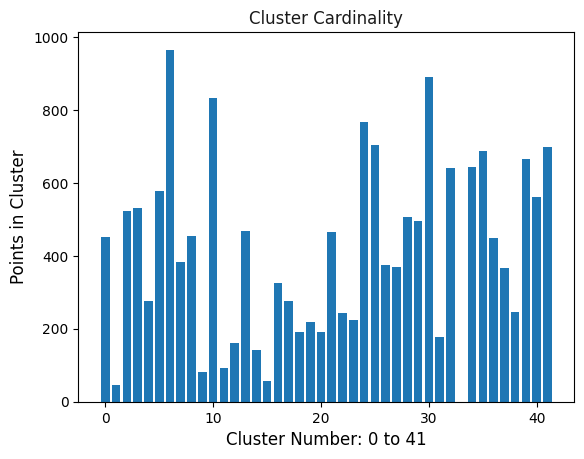

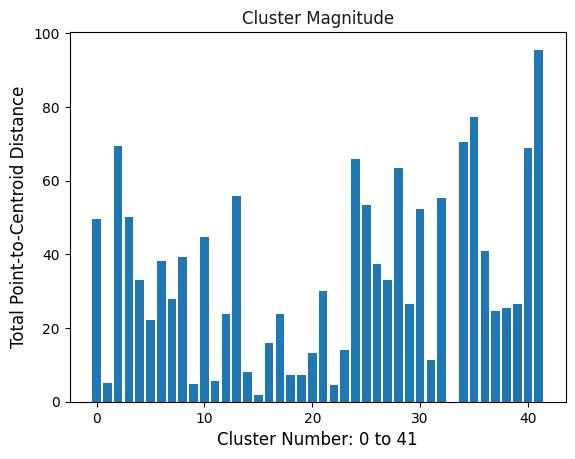

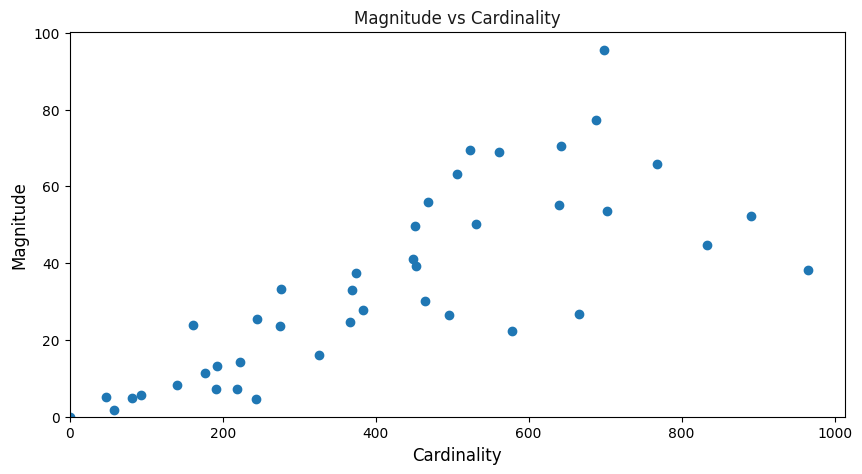

In [109]:
size = figsize=(10,5)

clusterQualityMetrics(copy_mi)

**Adding the cluster labels and `pt2centroids` data to the original mi_combined df**

In [110]:
for col in ['centroid', 'pt2centroid']:
    mi_combined.loc[:, col] = copy_mi[col]
print('done!')

done!


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [111]:
mi_combined.head()

,transaction_volume_usd,merchant_industry,otp_fraud,merchant_category,transaction_count,fraud_count,centroid,pt2centroid
0,231.590551,GOODS-PHYSICAL,0,e-Commerce,5,0,27,0.048029
1,210.203412,SERVICES-LEGAL,0,Other,2,0,16,0.047820
2,223.097113,TRAVEL,0,Travel & Hospitality,4,0,23,0.095639
3,212.335958,SERVICES-PROFESSIONAL,0,Other,5,0,27,0.066058
4,550.131234,SERVICES-DIGITAL,0,Digital Services,8,0,27,0.135270


In [112]:
# Let's again check for missing values

mi_combined.isna().any()

transaction_volume_usd    False
merchant_industry         False
otp_fraud                 False
merchant_category         False
transaction_count         False
fraud_count               False
centroid                  False
pt2centroid               False
dtype: bool

**Let's rank the clusters by the number of fraud-counts in them**

In [113]:
def rank_clusters(df, col, clusters, by='sum', sort=True):
    """Function to rank clusters by 
        some parameter
    """
    ind, count = [], []

    for cluster in clusters:
        temp = df[df['centroid'] == cluster]
        ind.append('clust_'+str(cluster))
        if by == 'sum':
            count.append(sum(temp[col]))

    serie = pd.Series(count, index=ind)
    if sort:
        serie = serie.sort_values(ascending=False)

    return serie

In [114]:
df = mi_combined
clusters = list(df['centroid'].unique())
col = 'fraud_count'
clusters_fraud_sum = rank_clusters(df, col, clusters=clusters) 
clusters_fraud_sum.head()

clust_24    927
clust_10    319
clust_37     39
clust_2      12
clust_0      10
dtype: int64

### 10. Exploring Cluster Similarities to Detect Fraud

**Plot `fraud_count` and `transaction_volume_usd` per top fraud clusters**

In [115]:
clusters = [int(x.split('_')[1]) for x in list(clusters_fraud_sum.index)][:10]
col = 'transaction_volume_usd'
clusters_trans_count = rank_clusters(df, col, clusters=clusters, sort=False) 
clusters_trans_count.head()

clust_24    3.556682e+07
clust_10    2.436324e+07
clust_37    3.248504e+07
clust_2     9.058883e+06
clust_0     3.733245e+06
dtype: float64

In [116]:
def plot_bubble_n_bar(s1, s2):

    assert len(s1) == len(s2), 'ERROR: Lengths Mismatch!'

    plt.figure(figsize=size)
    plt.suptitle('Fraud Count and Tranaction-Volume-USD: Top 10 Fraud Clusters',
                 fontdict=fontDict1,y=1.05)

    # normalize s1 for the bubble-plot
    s1 = s1.to_frame()
    s1.columns = ['count']
    s1['clust'] = [int(x.split('_')[1]) for x in list(s1.index)]

    # # get the normalised version
    norm_s1 = (s1['count'] - s1['count'].min()).div(s1['count'].max() - s1['count'].min())

    plt.subplot(122)
    
    plt.scatter(
        x='clust',
        y='count',
        color=colours,
        data=s1,
        s=norm_s1*3000+10
    )
    plt.title('Fraud-Count', fontdict=fontDict1)
    plt.xticks(rotation = 45)
    plt.xticks(ticks=list(s1.clust), labels=list(s1.index))
    
    plt.subplot(121)
    plt.bar(x=s2.index, height=list(s2), color=colours)
    plt.title('Transaction-Volume-USD', fontdict=fontDict1)
    plt.ylabel('volume_usd', fontdict=fontDict2)
    plt.xticks(rotation = 45)
    

    plt.show()

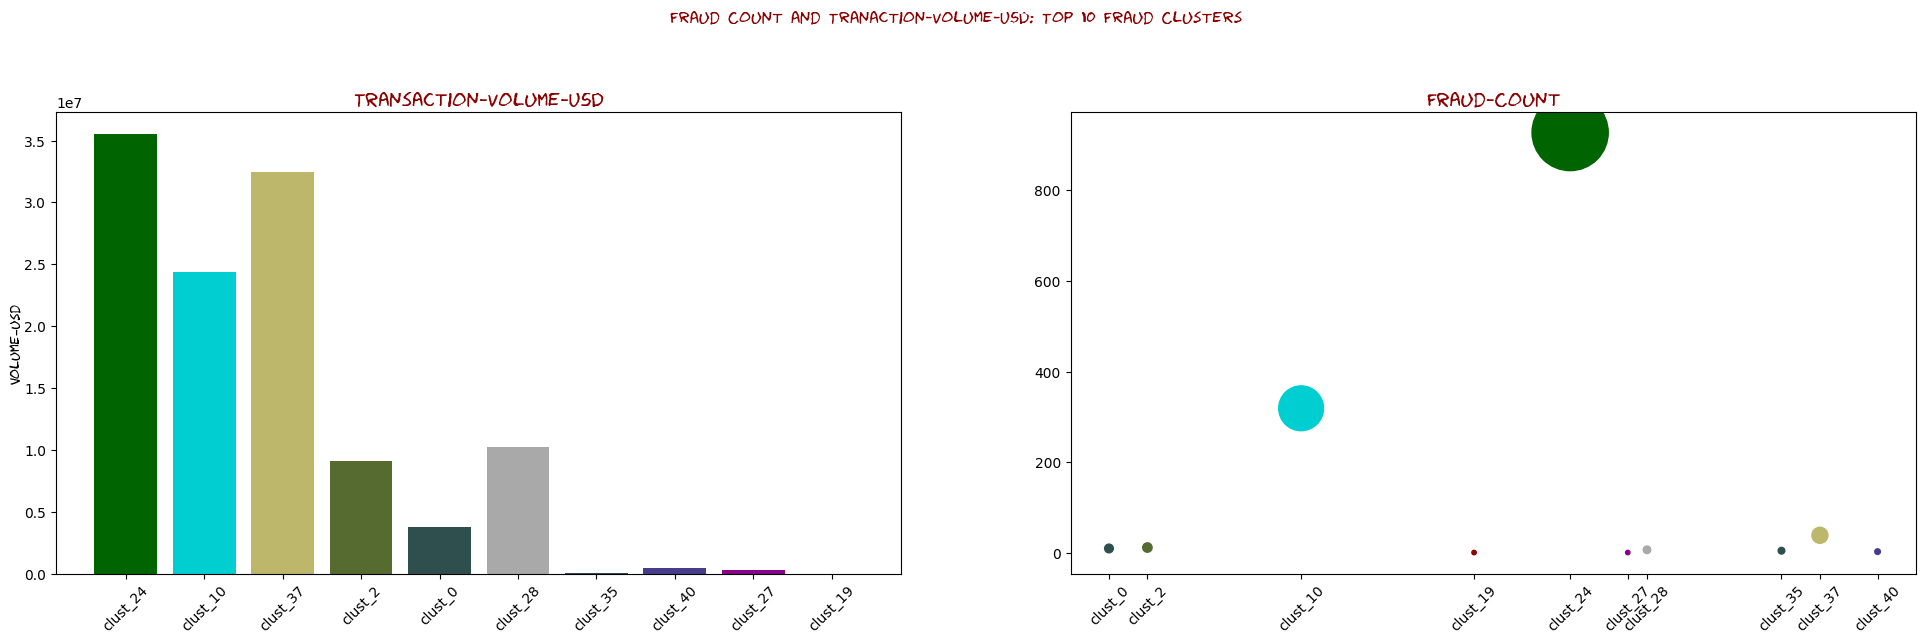

In [117]:
s1 = clusters_fraud_sum[:10]
s2 = clusters_trans_count
size = (24,6)
colours = random.sample(darker_colors, 10)

plot_bubble_n_bar(s1, s2)

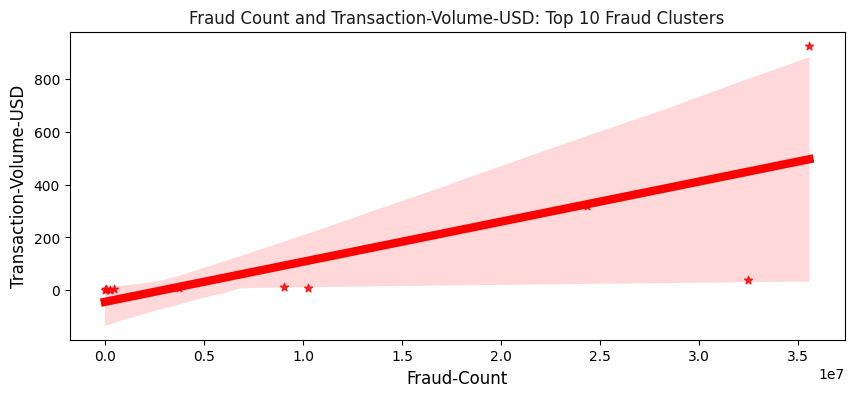

In [118]:
plt.figure(figsize=(10,4))
sns.regplot(x = s2, y=s1, marker='*', color='red')
plt.xlabel('Fraud-Count')
plt.ylabel('Transaction-Volume-USD')
plt.title('Fraud Count and Transaction-Volume-USD: Top 10 Fraud Clusters')
plt.show()

With Clustering, we can better see that `transaction-volume-usd` and `fraud-count` are correlated. This means, generally that as the value of transactions increase, so is the likelihood of fraud transactions.

**Let's explore the Top-Fraud Cluster**

In [119]:
top_fraud_cluster = [int(x.split('_')[1]) for x in list(clusters_fraud_sum.index)[:1]][0]
print(f'Top-Fraud-Cluster: {top_fraud_cluster}\n')

top_fraud_cluster_df = mi_combined.loc[mi_combined['centroid'] == top_fraud_cluster, :]
print(f'Top-Fraud-Cluster shape: {top_fraud_cluster_df.shape}\n')
top_fraud_cluster_df.head(10)

Top-Fraud-Cluster: 24

Top-Fraud-Cluster shape: (768, 8)



,transaction_volume_usd,merchant_industry,otp_fraud,merchant_category,transaction_count,fraud_count,centroid,pt2centroid
18,1.224458e+04,INTERNET,0,Utilities,396,0,24,0.024015
28,6.664698e+02,TELECOMS,0,Utilities,102,0,24,0.032923
33,1.340813e+03,TELECOMS,0,Utilities,119,0,24,0.040751
34,3.563845e+05,BETTING,3,Betting,16415,4,24,0.214494
50,1.005226e+03,BETTING,0,Betting,81,0,24,0.093831
60,2.039370e+02,TELECOMS,0,Utilities,61,0,24,0.058230
83,4.569554e+02,INTERNET,0,Utilities,20,0,24,0.051031
106,1.281890e+02,BETTING,0,Betting,30,0,24,0.126578
114,1.226247e+03,EDUCATION-SECONDARY,0,Education,258,0,24,0.070840
119,1.850069e+06,BETTING,11,Betting,247893,170,24,0.543007


**What industries make up this cluster?**

Let's use a word-cloud to see the industries that make up the Top-Fraud cluster..

In [120]:
# import package and its set of stopwords
from wordcloud import WordCloud
print ('Wordcloud is installed and imported!')

Wordcloud is installed and imported!


In [121]:
def plot_wordcloud(df, col, maxx=None, title=None):
    # select unique details
    wc_word_list = list(df[col].unique())

    # select count for each unique detail
    sub_totals = [len(df[df[col] == x]) for x in wc_word_list]

    # get a grand total
    total = sum(sub_totals)

    # assert both lists are equal
    assert len(wc_word_list) == len(sub_totals)

    # Next set max number of words for the WordCloud and the string of words
    max_words = maxx
    word_string = ''

    # Next iterate through both lists above and append the words
    for item, tot in zip(wc_word_list, sub_totals):
        if len(item.split(' ')) == 1:
            repeat_num_times = int(tot/total * max_words)
            word_string = word_string + ((item + ' ') * repeat_num_times)

    # create the word cloud and generate it in one line of code
    wordcloud = WordCloud(background_color= random.sample(other_colors,1)[0]).generate(word_string)

    # display the cloud
    fig = plt.figure(figsize=size)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontdict=fontDict1)
    plt.show()

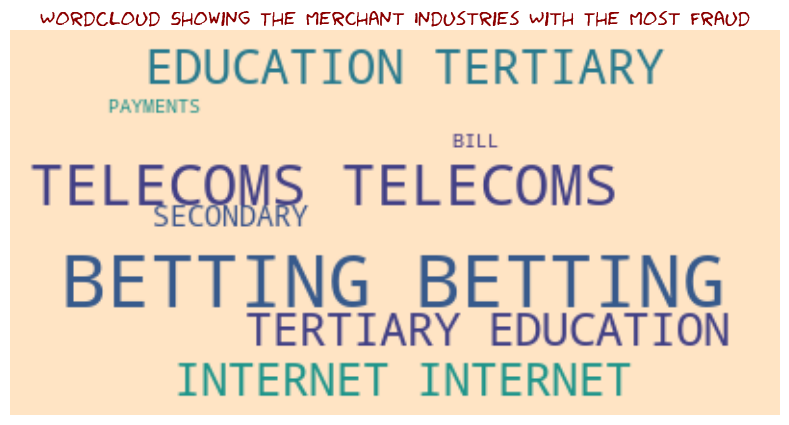

In [122]:
title = 'WordCloud Showing The Merchant Industries With The Most Fraud'
size = (15, 5)
maxx = 100

plot_wordcloud(top_fraud_cluster_df, 'merchant_industry', maxx=maxx, title=title)

In [123]:
def top_fraud_industry_split(df, col='merchant_industry'):

    count, name = [], []
    industries = list(df[col].unique())

    for industry in industries:
        temp = df[df[col] == industry]
        name.append(industry)
        count.append(sum(temp['fraud_count']))
    
    serie = pd.Series(count, index=name, name='Top Fraud Merchant Industries')
    serie = serie.sort_values(ascending=False)

    return serie

In [124]:
top_fraud_industries = top_fraud_industry_split(mi_combined)
top_fraud_industries

BETTING           921
LENDING           307
SAVINGS            36
GOODS-PHYSICAL     10
COOPERATIVES        9
                 ... 
EVENTS              0
LOTTERY             0
TELEMEDICINE        0
PAYROLL             0
PRESS-MEDIA         0
Name: Top Fraud Merchant Industries, Length: 63, dtype: int64

These once again show us the same Top-Industries we saw earlier, which are

1. BETTING
2. LENDING
3. SAVINGS
4. GOODS PHYSICAL
5. COOPERATIVES

The good thing now is that with these Top-5 are other industries with similar transactions as they are all clustered together. This means with activities like `controlled-experiments` and `A-B Testing` we can better learn insights as to why the spike in fraud activities, from these industries clustered together, as we fight Fraud. Because some of the industries in this cluster of top-fraud-merchants have zero fraud records. This means we could learn how such industries carry out similar tranactions as high-Risk merchants, without incurring fraud costs.

**Investigating the `Top-Fraud-Cluster`, let's look at the count & percentage of merchants who actually recorded fraud & who did not.**

In [125]:
top_fraud_cluster_df.head(3)

,transaction_volume_usd,merchant_industry,otp_fraud,merchant_category,transaction_count,fraud_count,centroid,pt2centroid
18,12244.575276,INTERNET,0,Utilities,396,0,24,0.024015
28,666.469843,TELECOMS,0,Utilities,102,0,24,0.032923
33,1340.812520,TELECOMS,0,Utilities,119,0,24,0.040751


In [126]:
no_fraud_count = len(top_fraud_cluster_df[top_fraud_cluster_df.fraud_count == 0])
fraud_count = len(top_fraud_cluster_df[top_fraud_cluster_df.fraud_count > 0])

assert (no_fraud_count + fraud_count) == len(top_fraud_cluster_df)
print('equal!')

equal!


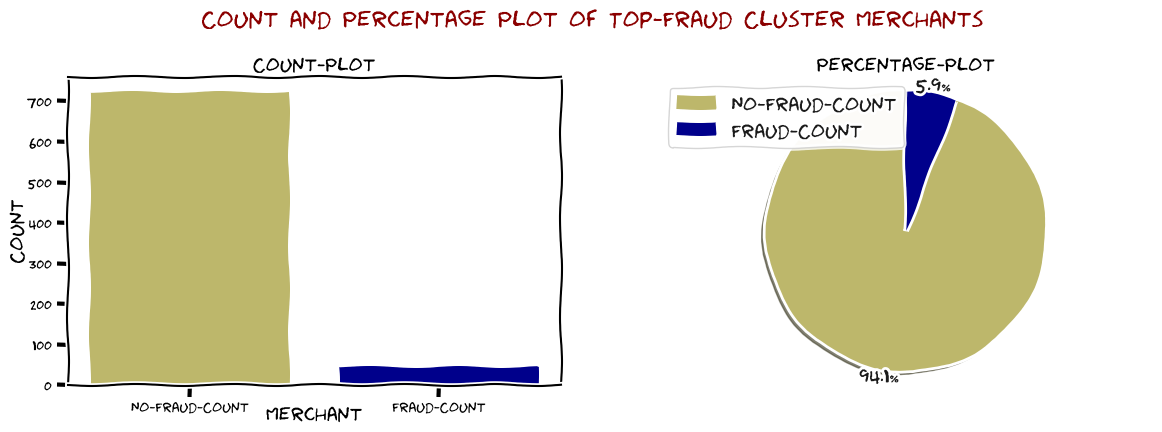

In [127]:
names = ['No-Fraud-Count', 'Fraud-Count']
loc = 'upper left'
titles = ['Count-Plot', 'Percentage-Plot']
val1, val2 = no_fraud_count, fraud_count
sup_title = 'Count and Percentage Plot of Top-Fraud Cluster Merchants'
colours = random.sample(darker_colors, 2)
size=(14,4)
plt.xkcd() # use xkcd style for this plot

plot_merchants_split(names, val1, val2, size, sup_title, loc=loc)

**Let's look at `OTP-Fraud` data per cluster**

Let's see the percentages of otp-fraud to total fraud for each of the top 5 fraud clusters

In [128]:
top_five_fraud_clusters = [int(x.split('_')[1]) for x in list(clusters_fraud_sum.index)[:5]]
top_five_fraud_clusters

[24, 10, 37, 2, 0]

In [129]:
top_five_fraud_cls_df = pd.DataFrame(columns=list(mi_combined.columns))
for i in top_five_fraud_clusters:
    temp = mi_combined[mi_combined.centroid == i]
    top_five_fraud_cls_df = pd.concat([top_five_fraud_cls_df, temp], ignore_index=True)

print(f'top 5 clusters df shape is: {top_five_fraud_cls_df.shape}\n')
top_five_fraud_cls_df.head()

top 5 clusters df shape is: (2942, 8)



,transaction_volume_usd,merchant_industry,otp_fraud,merchant_category,transaction_count,fraud_count,centroid,pt2centroid
0,12244.575276,INTERNET,0,Utilities,396,0,24,0.024015
1,666.469843,TELECOMS,0,Utilities,102,0,24,0.032923
2,1340.812520,TELECOMS,0,Utilities,119,0,24,0.040751
3,356384.474199,BETTING,3,Betting,16415,4,24,0.214494
4,1005.225696,BETTING,0,Betting,81,0,24,0.093831


In [130]:
col1 = 'centroid'
col2 = 'otp_fraud'
name = 'Percentage of OTP to Total-Fraud: Top 5 Fraud Cluster'

pct_split = groupby_to_series(top_five_fraud_cls_df, col1, col2, name=name)
pct_split.index = ['Cluster_'+str(i) for i in pct_split.index]
pct_split

Cluster_24    77.037037
Cluster_10    12.592593
Cluster_0      5.925926
Cluster_37     2.222222
Cluster_2      2.222222
Name: Percentage of OTP to Total-Fraud: Top 5 Fraud Cluster, dtype: float64

In [131]:
try:
    from pywaffle import Waffle
except:
    !pip install --quiet pywaffle
print('done!')
plt.rcdefaults()

     |████████████████████████████████| 526 kB 2.1 MB/s 
done!


In [132]:
from pywaffle import Waffle

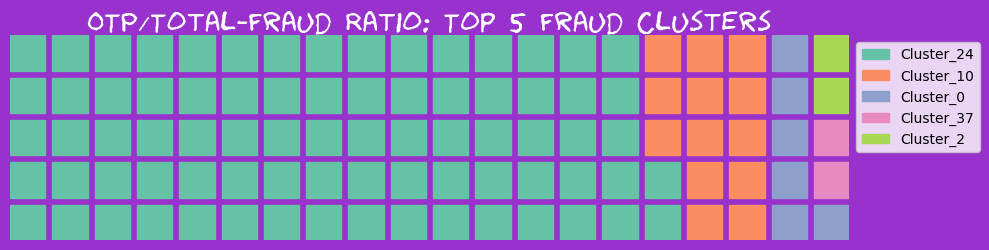

In [133]:
fontDict2['color'] = 'white'

fig = plt.figure(
    FigureClass = Waffle,
    rows = 5,
    values = pct_split,
    labels = list(pct_split.index),
    facecolor= random.sample(darker_colors, 1)[0],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    title={
        'label': 'OTP/Total-Fraud Ratio: Top 5 Fraud Clusters',
        'loc': 'center',
        'fontdict': fontDict2,
            'fontsize': 20},
    figsize=(10,5)
)


### 11. So What Caused The Spike in Fraud Cases?

**Causation**

According to The [Google Machine-Learning Course](https://developers.google.com/machine-learning/problem-framing/hard), Machine Learning can identify correlations:— mutual relationships or connections between two or more things. Determining causation _(one event or factor causing another)_ is much harder. 

In other words, it is easy to see that something happened, but much harder to understand why it happened. We can't determine causation from only observational data. As in the example above, we can't determine whether the high transactions count for high-risk merchants caused the spike in fraud entirely. 

We would need to run an experiment, comparing users who didn't record fraud especially within the same clusters, with similar users who did. In general, we need to intervene in the world of our merchants and run a largely controlled experiment to determine causation; We can't see it in purely observational data alone.

**Saving important data**

In [134]:
combined_df.to_csv('combined_df.csv', index=False)
mi_combined.to_csv('mi_combined.csv', index=False)
top_five_fraud_cls_df.to_csv('top_five_clusters.csv', index=False)
top_fraud_cluster_df.to_csv('top_fraud_cluster.csv', index=False)
print('All saved!')

All saved!
